#### Imports

In [6]:
import kagglehub
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import cv2
import numpy as np
import math
import albumentations as A

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/albumentations/check_version.py:107: UserWarning: Error fetching version info <urlopen error [SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1000)>
  data = fetch_version_info()


#### Download ISIC-2019

In [9]:
# Download latest version
path = kagglehub.dataset_download("andrewmvd/isic-2019")

print("Path to dataset files:", path)

Resuming download from 7514095616 bytes (2254068362 bytes left)...
Resuming download from https://www.kaggle.com/api/v1/datasets/download/andrewmvd/isic-2019?dataset_version_number=1 (7514095616/9768163978) bytes left.


100%|██████████| 9.10G/9.10G [06:33<00:00, 5.73MB/s]

Extracting files...


Path to dataset files: /Users/nathanong/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1


#### Filter Functions
Grayscale, Hair Removal, Noise Reduction, and Contrast Enhancement

In [10]:
def filter_all_images(image_folder: str, output_folder: str, image_files: list[str]) -> None:
    """
    Apply all filtering functions to a list of image files.
    
    image_files: List of image file names
    """
    for image_file in image_files:
        try:
            filter_image(image_folder, output_folder, image_file)
        except Exception as e:
            print(f"Error processing image {image_file}: {e}")

def filter_image(image_folder: str, output_folder: str, image_file: str) -> None:
    """
    Apply all filtering functions to a single image file.
    
    image_file: Image file name
    """
    image_path = os.path.join(image_folder, image_file)
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error loading image: {image_file}")
    else:
        image_gr = grayscale(image)
        image_hr = hair_removal(image_gr)
        image_nr = noise_reduction(image_hr)
        image_ce = contrast_enhancement(image_nr)

        image_final = image_nr
        output_path = os.path.join(output_folder, image_file)
        cv2.imwrite(output_path, image_final)

def grayscale(image: np.ndarray) -> np.ndarray:
    """Convert the image to grayscale."""
    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

def hair_removal(image: np.ndarray) -> np.ndarray:
    """Apply hair removal filter to the image using the Dull Razor algorithm."""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))  # creates a kernel for morphing
    blackhat = cv2.morphologyEx(image, cv2.MORPH_BLACKHAT, kernel)  # apply blackhat filter (highlights dark regions)
    bhg = cv2.GaussianBlur(blackhat, (9, 9), cv2.BORDER_REPLICATE)  # smooths image
    _, mask = cv2.threshold(bhg, 50, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)  # creates a binary mask to detect hair-like structure
    image_bgr = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    inpainted_image = cv2.inpaint(image_bgr, mask, 4, cv2.INPAINT_TELEA)
    # Convert back to grayscale
    return cv2.cvtColor(inpainted_image, cv2.COLOR_BGR2GRAY)

def noise_reduction(image: np.ndarray) -> np.ndarray:
    """Apply noise reduction to the image using Median Filtering and Bilateral Filtering."""
    image_mf = cv2.medianBlur(image, 5)  # Apply median filter to reduce salt and pepper noise
    image_bf = cv2.bilateralFilter(image_mf, d=17, sigmaColor=100, sigmaSpace=100)  # Apply bilateral filter to reduce noise while preserving edges
    return image_bf

def contrast_enhancement(image: np.ndarray) -> np.ndarray:
    """Apply contrast enhancement to the image using Histogram Equalization."""
    # Check if the image is grayscale
    if len(image.shape) == 2:
        # Apply Adaptive Histogram Equalization (CLAHE)
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        return clahe.apply(image)
    else:
        print("Error: Image is not grayscale, cannot apply histogram equalization.")
        return image

#### Preprocessing Functions
Updating Labeling, Data Augmentation, Resizing

In [11]:
def augment_data(output_folder: str, transform_func, data_frame: pd.DataFrame) -> None:
    """
    Augment images with MEL = 1 to create a new balanced dataset.

    output_folder (str): Path to the folder where augmented images and the new DataFrame will be saved.
    transform_func (Compose): albumentations transformation function.
    data_frame (pd.DataFrame): Original DataFrame containing image data.
    """
    # Ensure the output folder exists
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Create a new DataFrame to store the balanced dataset
    balanced_data = []

    for _, row in data_frame.iterrows():
        image_name = row["image"]
        image_path = os.path.join(output_folder, f"{image_name}.jpg")
        image = cv2.imread(image_path)

        if image is None:
            print(f"Error: Could not load image {image_path}")
            continue

        # Add the original row to the balanced dataset
        balanced_data.append(row)

        # If MEL == 1, augment the image and save 3 transformed copies
        if row["MEL"] == 1:
            for i in range(1, 4):  # Create 3 augmented copies
                augmented = transform_func(image=image)
                transformed_image = augmented["image"]
                augmented_name = f"{image_name}_{i}.jpg"
                augmented_path = os.path.join(output_folder, augmented_name)
                cv2.imwrite(augmented_path, transformed_image)

                # Add the new row to the balanced dataset
                new_row = row.copy()
                new_row["image"] = f"{image_name}_{i}"  # Update the image name
                balanced_data.append(new_row)

    # Create a new DataFrame from the balanced data
    df_balanced = pd.DataFrame(balanced_data, columns=data_frame.columns)

    # Save the balanced DataFrame to the output folder
    df_balanced_path = os.path.join(output_folder, "ISIC_2019_Training_Balanced.csv")
    df_balanced.to_csv(df_balanced_path, index=True)

    print(f"\nAugmentation and balancing complete. Balanced DataFrame saved to {df_balanced_path}.")

def resize_images(folder: str, target_size=(224, 224)):
    """
    Resize all jpg images in a folder to the target size.

    folder: Path to the folder containing images
    target_size: Tuple specifying the target size (width, height)
    """
    for filename in os.listdir(folder):
        if filename.endswith('.jpg') or filename.endswith('.jpeg'):
            image_path = os.path.join(folder, filename)
            image = cv2.imread(image_path)
            if image is None:
                print(f"Error loading image: {filename}")
                continue
            
            resized_image = cv2.resize(image, target_size)
            cv2.imwrite(image_path, resized_image)  # Save the resized image back to the same path

#### View Functions

In [12]:
def num_melanoma(data_frame: pd.DataFrame) -> int:
    # Count number of melanoma vs non-melanoma
    melanoma_count = data_frame[data_frame["MEL"] == 1].shape[0]
    non_melanoma_count = data_frame[data_frame["MEL"] == 0].shape[0]

    print(f"\nMelanoma images: {melanoma_count}")
    print(f"Non-Melanoma images: {non_melanoma_count}")

    # Percent distribution
    print("\nMEL column class distribution (%):")
    print(data_frame["MEL"].value_counts(normalize=True) * 100)

def view_images(folder: str, image_files: list[str], num=0) -> None:
    """
    View a subset of images from the dataset.

    image_files: List of image file names
    num: Number of images to display
    """
    if num == 0:
        num = len(image_files)
    n_rows = math.ceil(num // 5)
    n_cols = 5
    plt.figure(figsize=(n_cols * 3, n_rows * 5))  # Adjust figure size dynamically
    for i, image_file in enumerate(image_files[:num]):
        image_path = os.path.join(folder, image_file)
        img = mpimg.imread(image_path)
        
        plt.subplot(n_rows, n_cols, i + 1)
        # Check if the image is grayscale
        if len(img.shape) == 2 or (len(img.shape) == 3 and img.shape[2] == 1):
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        plt.title(image_file, fontsize=8)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

#### Path Setup

In [18]:
base_path = '/Users/nathanong/.cache/kagglehub/datasets/andrewmvd/isic-2019/versions/1'  # Update this path as needed
image_folder = os.path.join(base_path, 'ISIC_2019_Training_Input', 'ISIC_2019_Training_Input')
labels_path = os.path.join(base_path, 'ISIC_2019_Training_GroundTruth.csv')
output_folder = '../preprocessed_dataset'  # Update this path as needed
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
balanced_csv_path = os.path.join(output_folder, 'ISIC_2019_Training_Balanced.csv')

#### View Images

Total .jpg files found: 25331
Sample image names: ['ISIC_0030858.jpg', 'ISIC_0030680.jpg', 'ISIC_0033389.jpg', 'ISIC_0032097.jpg', 'ISIC_0054312.jpg']

Images before preprocessing:


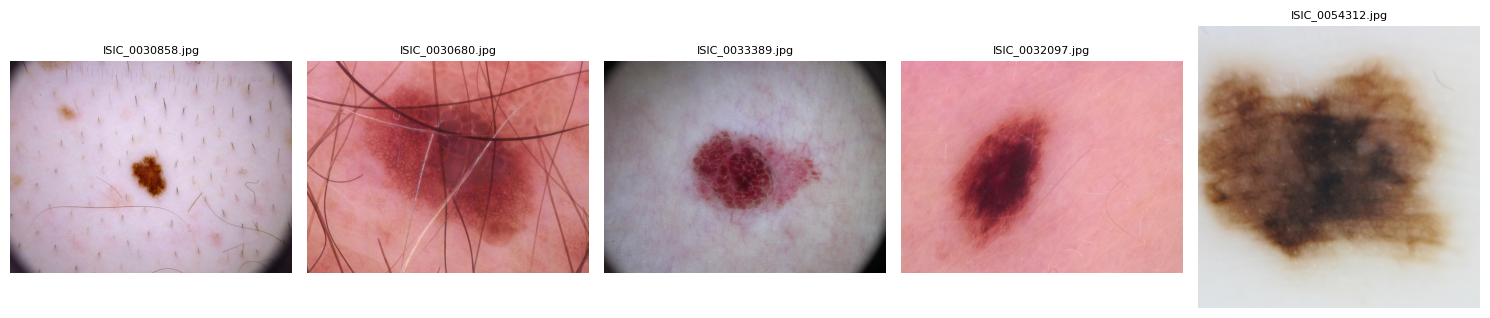

In [19]:
# === Check Images ===
# List only .jpg image files (ignore folders)
image_files = [f for f in os.listdir(image_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(image_folder, f))]

print("Total .jpg files found:", len(image_files))
print("Sample image names:", image_files[:5])

# === Visualize First 5 Images ===
print("\nImages before preprocessing:")
view_images(image_folder, image_files, 5)

#### Filter All Images


Images after filtering:


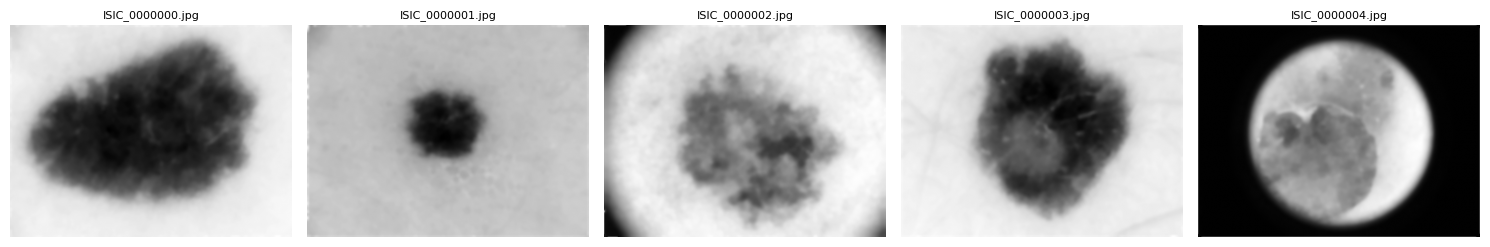

In [20]:
# === Filtering and Preprocessing ===

# Testing with first 5 images
# filter_all_images(image_folder, output_folder, image_files[:5])

filter_all_images(image_folder, output_folder, image_files)
print("\nImages after filtering:")
result_files = [f for f in os.listdir(output_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(output_folder, f))]
result_files.sort()
view_images(output_folder, result_files, 5)
# view_images(output_folder, result_files)

#### Load DataFrame

In [21]:
# === Load Labels CSV ===
df = pd.read_csv(labels_path)
print("\nTraining labels preview:")
print(df.head())

# === Melanoma vs. Non-Melanoma ===
num_melanoma(df)  # Display the number of melanoma vs non-melanoma images


Training labels preview:
          image  MEL   NV  BCC   AK  BKL   DF  VASC  SCC  UNK
0  ISIC_0000000  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
1  ISIC_0000001  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
2  ISIC_0000002  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
3  ISIC_0000003  0.0  1.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0
4  ISIC_0000004  1.0  0.0  0.0  0.0  0.0  0.0   0.0  0.0  0.0

Melanoma images: 4522
Non-Melanoma images: 20809

MEL column class distribution (%):
MEL
0.0    82.148356
1.0    17.851644
Name: proportion, dtype: float64


#### Data Augmentation

In [22]:
transform = A.Compose([
    A.Rotate(limit=30, p=0.5), # limit 30 degrees
    A.HorizontalFlip(p=0.5), 
    A.RandomBrightnessContrast(p=0.2)
])
print("\nApplying data augmentation to balance the dataset...")
augment_data(output_folder, transform, df)


Applying data augmentation to balance the dataset...

Augmentation and balancing complete. Balanced DataFrame saved to ../preprocessed_dataset/ISIC_2019_Training_Balanced.csv.


#### Preview Augmented Dataset

In [23]:
df_balanced = pd.read_csv(balanced_csv_path)
df_balanced = df_balanced[['image', 'MEL']]
df_balanced.to_csv(balanced_csv_path, index=True)
print(f"Updated CSV saved to {balanced_csv_path}")

print("\nBalanced dataset preview:")
print(df_balanced.head())
num_melanoma(df_balanced)  # Display the number of melanoma vs non-melanoma images

Updated CSV saved to ../preprocessed_dataset/ISIC_2019_Training_Balanced.csv

Balanced dataset preview:
            image  MEL
0    ISIC_0000000  0.0
1    ISIC_0000001  0.0
2    ISIC_0000002  1.0
3  ISIC_0000002_1  1.0
4  ISIC_0000002_2  1.0

Melanoma images: 18088
Non-Melanoma images: 20809

MEL column class distribution (%):
MEL
0.0    53.497699
1.0    46.502301
Name: proportion, dtype: float64


#### Resize Images


Resizing images to 224x224...

Total resized images: 38897


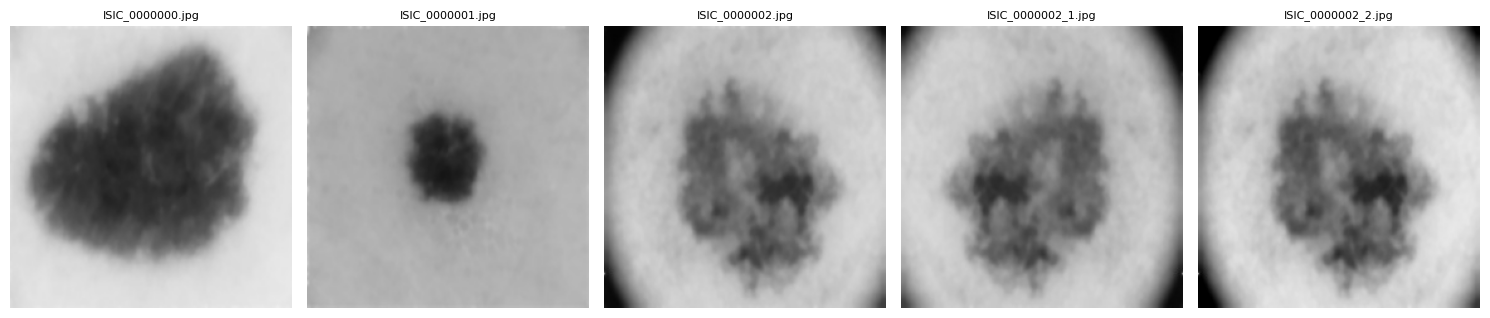

In [24]:
# Resize all images in the output folder to 224x224
print("\nResizing images to 224x224...")
resize_images(output_folder)
# Check resized images
resized_files = [f for f in os.listdir(output_folder) if f.endswith('.jpg') and os.path.isfile(os.path.join(output_folder, f))]
resized_files.sort()
print(f"\nTotal resized images: {len(resized_files)}")
# Visualize first 5 resized images
view_images(output_folder, resized_files, 5)